In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets

torch.manual_seed(1)
import matplotlib.pyplot as plt
%matplotlib inline

### Softmax 

$$softmax(x) = \frac{exp(x_i)}{\sum_j exp(x_j)}$$

In [3]:
z = torch.Tensor([2.0,1.0,0.1])

def softmax(z):
    exps = torch.exp(z)
    return exps / torch.sum(exps)

print(softmax(z))
print(torch.sum(softmax(z)))
print("")

res = F.softmax(Variable(z),0) 
print(res)                  
print(torch.sum(res)) 


 0.6590
 0.2424
 0.0986
[torch.FloatTensor of size 3]

0.9999999552965164

Variable containing:
 0.6590
 0.2424
 0.0986
[torch.FloatTensor of size 3]

Variable containing:
 1.0000
[torch.FloatTensor of size 1]



### Cross entropy 

$$H(p,q)=-\sum_xp(x)logq(x)$$

In [4]:
predict_1 = torch.Tensor([0.7,0.2,0.1])
predict_2 = torch.Tensor([0.01,0.9,0.99])

target = torch.Tensor([1.0,0.,0.])

def cross_entropy(q,p):
    return -torch.sum(p*torch.log(q))

print(cross_entropy(predict_1,target)) # 옳게 예측 -> low loss(cost)
print(cross_entropy(predict_2,target)) # 틀리게 예측 --> high loss(cost)

# in practical 

predict_1  = torch.Tensor([2.,1.,0.1])
predict_2 = torch.Tensor([1.,2.,0.1])
target = torch.LongTensor([0])

loss_function = nn.CrossEntropyLoss() # softmax 연산을 포함하고 있음
loss1 = loss_function(Variable(predict_1).view(1,-1),Variable(target))
loss2 = loss_function(Variable(predict_2).view(1,-1),Variable(target))

print(loss1.data[0])
print(loss2.data[0])

0.3566749691963196
4.605170249938965
0.41703000664711
1.4170299768447876


### MNIST dataset

In [2]:
train_dataset = vdatasets.MNIST(root='../../data/MNIST/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.MNIST(root='../../data/MNIST/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

In [3]:
print(train_dataset[0][0].size())
print(train_dataset[0][1])

torch.Size([1, 28, 28])
5


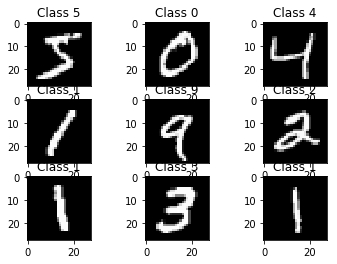

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_dataset[i][1]))

### 모델링

In [20]:
class NN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NN,self).__init__()
        
        self.l1 = nn.Linear(input_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,output_size)
        
    def forward(self,inputs):
        outputs = F.relu(self.l1(inputs))
        return self.l2(outputs)

In [21]:
EPOCH=5
LR=0.01
BATCH_SIZE=64

model = NN(784,512,10)
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.SGD(model.parameters(), lr=LR)

$$loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j]))) = -x[class] + log(\sum_j exp(x[j]))$$

### 트레이닝 

In [22]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs).view(-1,784), Variable(targets)
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 100 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/5] [000/938] mean_loss : 2.338
[0/5] [100/938] mean_loss : 2.188
[0/5] [200/938] mean_loss : 1.907
[0/5] [300/938] mean_loss : 1.573
[0/5] [400/938] mean_loss : 1.237
[0/5] [500/938] mean_loss : 1.018
[0/5] [600/938] mean_loss : 0.856
[0/5] [700/938] mean_loss : 0.752
[0/5] [800/938] mean_loss : 0.680
[0/5] [900/938] mean_loss : 0.621
[1/5] [000/938] mean_loss : 0.547
[1/5] [100/938] mean_loss : 0.571
[1/5] [200/938] mean_loss : 0.552
[1/5] [300/938] mean_loss : 0.506
[1/5] [400/938] mean_loss : 0.476
[1/5] [500/938] mean_loss : 0.471
[1/5] [600/938] mean_loss : 0.448
[1/5] [700/938] mean_loss : 0.460
[1/5] [800/938] mean_loss : 0.425
[1/5] [900/938] mean_loss : 0.422
[2/5] [000/938] mean_loss : 0.632
[2/5] [100/938] mean_loss : 0.422
[2/5] [200/938] mean_loss : 0.416
[2/5] [300/938] mean_loss : 0.385
[2/5] [400/938] mean_loss : 0.387
[2/5] [500/938] mean_loss : 0.380
[2/5] [600/938] mean_loss : 0.387
[2/5] [700/938] mean_loss : 0.367
[2/5] [800/938] mean_loss : 0.366
[2/5] [900/938

### 테스트 

In [23]:
num_equal=0
for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = Variable(inputs).view(-1,784), Variable(targets)
    outputs = model(inputs)
    
    outputs = outputs.max(1)[1] # argmax
    num_equal += torch.eq(outputs,targets).sum().data[0]
    
    
print("Accuracy : " ,num_equal/len(test_dataset))

Accuracy :  0.9186


### TODO 

$$J(\theta) = -log(exp(x[class]) / (\sum_j exp(x[j]))) = -x[class] + log(\sum_j exp(x[j]))$$

The model architecture used for this task is just plain neural network. We used 2 hidden layers and the number of each node is 1024. The ReLU was used for activation function. In output layer, model transfromed its score to probability using softmax. And It got its loss with cross entropy. We used SGD optimizer with minibatch size of 32 and learning rate is 0.01.